Представим, что мы работаем в компании, которая разрабатывает мобильные игры. К нам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения.

Задача №1
В первую очередь, его интересует показатель retention. Наша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).
Для начала импортируем нужгные нам библиотеки, а также загрузим исходные датафреймы, reg_data - хранит в себе информацию о зарегестрированных пользователях, auth_data - сессии этих пользователей по датам.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [4]:
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-bogdan-41/shared/problem1-reg_data.csv', sep = ';')
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-bogdan-41/shared/problem1-auth_data.csv', sep = ';')

Даты хранятся в UNIX time формате, переведем их в привычный формат, а также уберем часть со временем, оставив лишь даты по дням.

In [6]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts']).dt.normalize()
reg_data = reg_data.rename(columns = {'reg_ts': 'date_reg'})

In [7]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts']).dt.normalize()
auth_data = auth_data.rename(columns = {'auth_ts': 'last_auth'})

Проверим датафреймы на наличие пустых значений.

In [8]:
reg_data.isna().sum()

date_reg    0
uid         0
dtype: int64

In [9]:
auth_data.isna().sum()

last_auth    0
uid          0
dtype: int64

Преобразуем изначальный датафрейм с сессиям в новый, содержащий информацию о последней сессии пользователя.

In [10]:
auth_data = auth_data.groupby('uid', as_index = False).agg({'last_auth': 'max'})

Объеденим получившийся датафрейм с базой данных зарегистрированных пользователей, также проверим на наличие пустых значений.

In [11]:
retention_df = reg_data.merge(auth_data, on = 'uid')

In [12]:
retention_df = retention_df[['uid', 'date_reg', 'last_auth']]

In [13]:
retention_df.isna().sum()

uid          0
date_reg     0
last_auth    0
dtype: int64

Рассчитаем новую колонку с информацией о прошедших днях между регистрацией пользователя и его последней сессией. На основе этих данных создадим новый датафрейм, включающий в себя количество дней, проведенных ползователями в нашем приложении, и само количество таких пользователей. 

In [14]:
df = retention_df

In [15]:
df['ret_day'] = (df.last_auth - df.date_reg).dt.days

In [16]:
df_full_retention = df.groupby('ret_day').agg({'uid': 'count'})

In [17]:
df_full_retention

,uid
ret_day,
0,761622
1,1689
2,3468
3,3941
4,4645
...,...
5253,1
5295,1
5353,1


Визуализируем получившиеся данные.
Построим дистплот для беглого анализа, увидим, что получившийся график плохо отражает необходимую нам информацию, т.к. ось с 0 днём является выбросом и затмевает собой все остальные дни.
Есть несколько вариантов решения этой проблемы - сгладить график использую логарифмы, или же исключить выиброс из графика.
Я выбрал второй вариант, т.к. значения остальных дней имеют более плавное распределение на графике, и использование логарифма, по факту, принесет пользу только для 1 значения (0 день), поэтому проще это значение прсото исключить.
Но точные значения для 0 дня всё же следует рассчитать и запомнить.

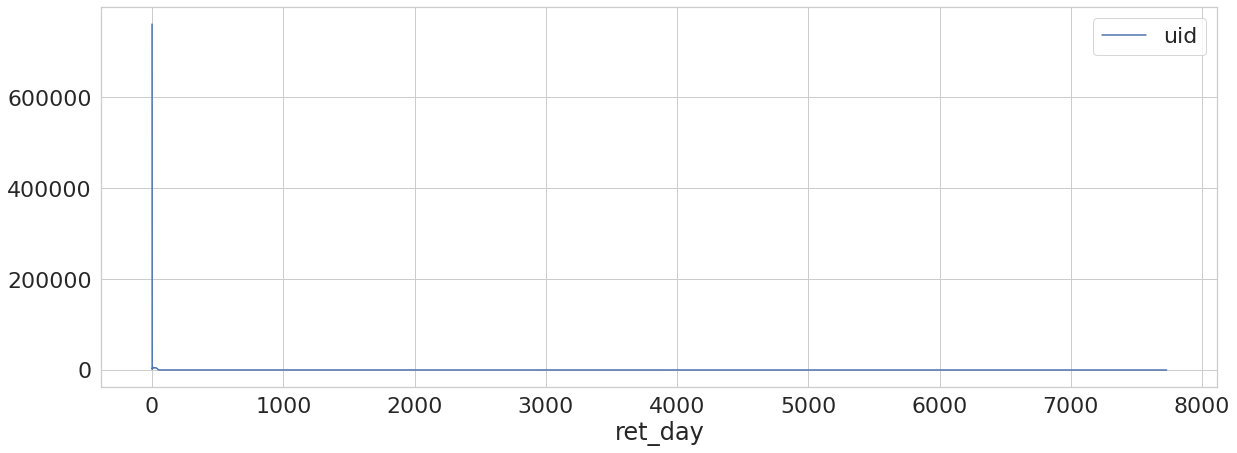

In [18]:
df_full_retention.plot()

In [16]:
df.ret_day.value_counts()

0       761622
6         6060
5         5294
7         5239
12        5154
         ...  
2153         1
1639         1
3372         1
3053         1
5212         1
Name: ret_day, Length: 3029, dtype: int64

In [19]:
df.ret_day.value_counts(normalize = True) * 100

0       76.1622
6        0.6060
5        0.5294
7        0.5239
12       0.5154
         ...   
2153     0.0001
1639     0.0001
3372     0.0001
3053     0.0001
5212     0.0001
Name: ret_day, Length: 3029, dtype: float64

Итого в день регистрации отвалилось 761622 пользователей, что составляет 76.1622 % от всех пользоваетелей.
Запомним получившиеся значения и создадим новый датафрейм без этих пользователей, также визуализируем его.

In [20]:
df_without_0_days = df.query('ret_day != "0"').groupby('ret_day').agg({'uid': 'count'})

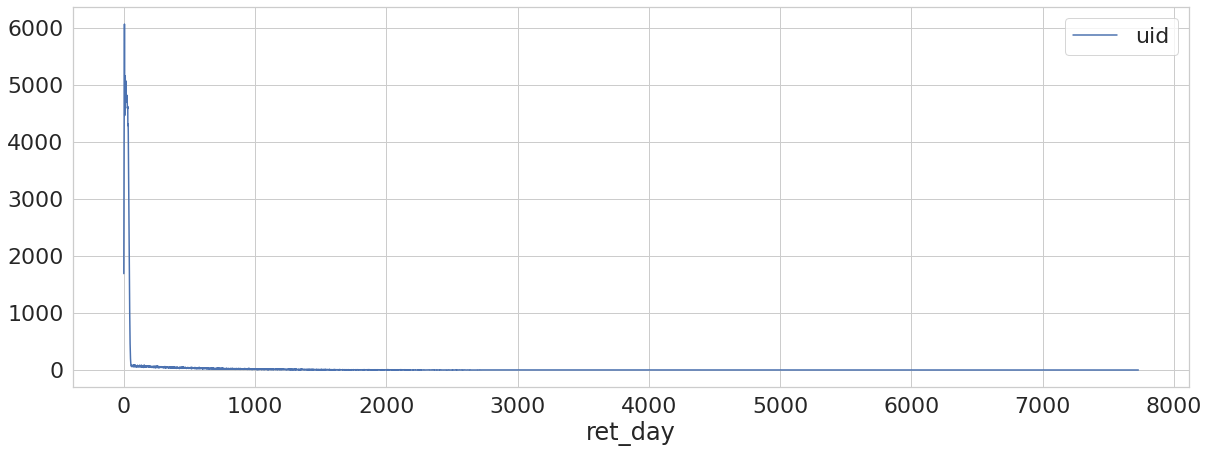

In [21]:
df_without_0_days.plot()

In [22]:
df_without_0_days

,uid
ret_day,
1,1689
2,3468
3,3941
4,4645
5,5294
...,...
5253,1
5295,1
5353,1


Получившийся график лучше отображает retention пользователей, но всё же не идеален - лишь небольшая левая часть что-то позволяет нам понять о поведении наших пользователей. Рассчитаем пороговый день, включающий в себя 95% наших оставшихся наблюдений и построим на основе этих данных новый график.

In [23]:
df.query('ret_day != "0"').ret_day.quantile(q = 0.82)

93.0

In [24]:
df_1_872_days = df.query('0 < ret_day < 873').groupby('ret_day').agg({'uid': 'count'})

Text(0.5, 1.0, 'Daily retention')

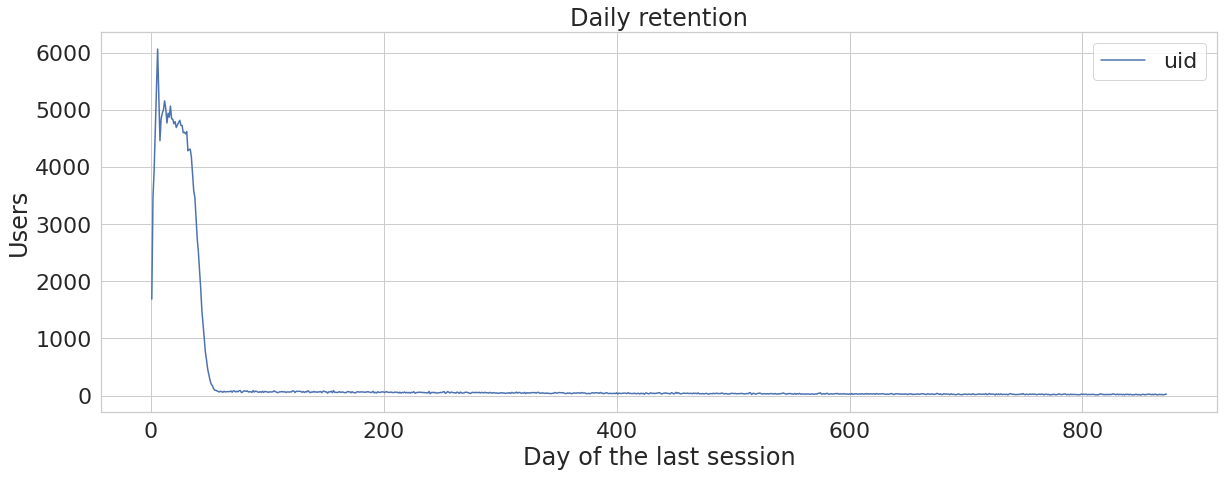

In [57]:
ax = df_1_872_days.plot()
ax.set_xlabel('Day of the last session')  # Label of x axis
ax.set_ylabel('Users')  # Label of y axis
ax.set_title('Daily retention')  # Title of the plot

Вывод.
Из зарегестрировавшегося 1000000 пользователей 76,16% не заходили в приложение не в один из последующих дней, из оставшихся пользователей 81 % отвалились в течение 60 дней, остальные пользователи пробыли в приложении от 61 до 7729 дней.

Напишем функцию принимающую два наших изначальных датафрейма и считающую Retention по дням за определенный период регистрации пользователей. Функция принимает 5 аргументов - оба изначальных датафрейма, дата начала отслеживаемого периода, дата конца отслеживаемого периода, максимальная продолжительность отслеживаемого Retention в днях.
После обработки данных возвращается датафрейм с данными о пользователях (абсолютное количество и % от общей массы) по дням возвращаемости, а также визуализация этого датафрейма.

In [112]:
def calculating_retention(reg_data, auth_data, start, end, duration):
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts']).dt.normalize()
    reg_data = reg_data.query('@start <= reg_ts <= @end').rename(columns = {'reg_ts': 'date_reg'})
    
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts']).dt.normalize()
    auth_data = auth_data.rename(columns = {'auth_ts': 'last_auth'})
    
    df = reg_data.merge(auth_data, on = 'uid')
    df = df[['uid', 'date_reg', 'last_auth']]
    df['ret_day'] = (df.last_auth - df.date_reg).dt.days
    df = df.query('ret_day <= @duration')
    
    df = df.groupby('ret_day', as_index = False).agg({'uid': 'count'}).rename(columns = {'uid': 'users'})
    df['percent_users'] = round(df.users / df.users.sum() * 100, 2)
    
    ax = sns.lineplot(data = df, x = 'ret_day', y = 'percent_users')
    ax.set_xlabel('Day of the last session')
    ax.set_ylabel('% users')
    ax.set_title('Daily retention')
    
    return df

Проверим работоспособность нашей функции.

In [113]:
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-bogdan-41/shared/problem1-reg_data.csv', sep = ';')
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-bogdan-41/shared/problem1-auth_data.csv', sep = ';')
start = '2020-01-01'
end = '2020-02-01'
duration = 30

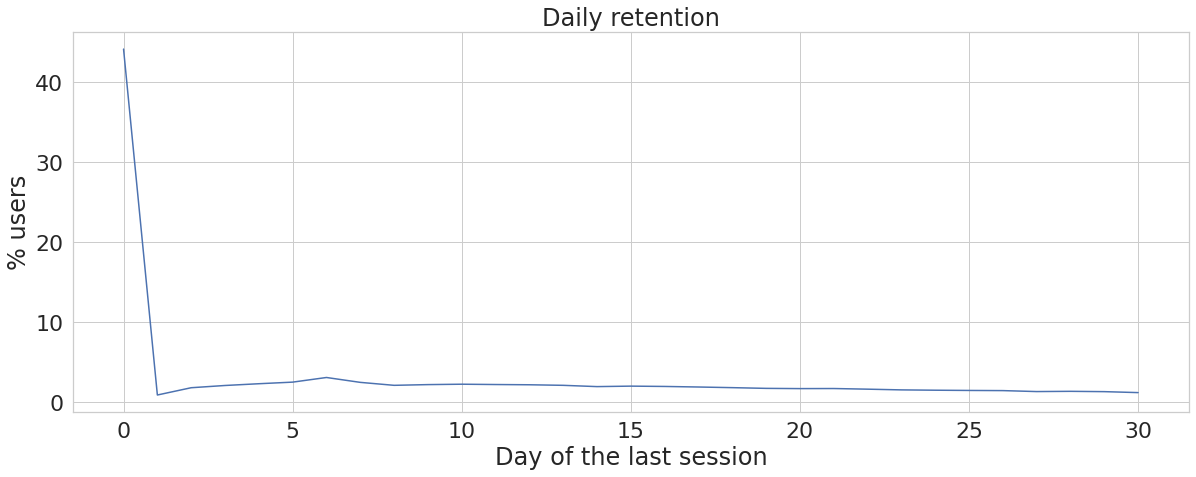

In [114]:
test = calculating_retention(reg_data, auth_data, start, end, duration)

In [115]:
test

,ret_day,users,percent_users
0,0,34850,44.16
1,1,708,0.90
2,2,1431,1.81
3,3,1651,2.09
4,4,1827,2.31
5,5,1982,2.51
6,6,2435,3.09
7,7,1961,2.48
8,8,1666,2.11
9,9,1739,2.20
